In [56]:
# import packages
import pandas as pd

# Loading files

# Roberta load
df_text_test = pd.read_csv('/Volumes/T7/OMSCS/CLEF2025/EXIST2025/exist-2025/notebooks/late_fusion/models_outputs/Roberta/text_test_predictions.csv')
df_text_train = pd.read_csv('/Volumes/T7/OMSCS/CLEF2025/EXIST2025/exist-2025/notebooks/late_fusion/models_outputs/Roberta/text_train_predictions.csv')
df_text_valid = pd.read_csv('/Volumes/T7/OMSCS/CLEF2025/EXIST2025/exist-2025/notebooks/late_fusion/models_outputs/Roberta/text_val_predictions.csv')

In [57]:
df_text = pd.concat([df_text_test, df_text_valid, df_text_train])
df_text = df_text.rename(columns={'prob_class_1': 'text_probs'})
df_text = df_text.drop(columns=['true_label', 'pred_label', 'prob_class_0'])
print(df_text.shape)
df_text.head()

(973, 2)


,video,text_probs
0,6910747250536893701.mp4,0.919632
1,6998726239087250693.mp4,0.005660
2,6898724802001997057.mp4,0.997183
3,6977700217835638021.mp4,0.999915
4,6841534512518761733.mp4,0.003149


In [58]:
# Audio load
df_audio = pd.read_csv('/Volumes/T7/OMSCS/CLEF2025/EXIST2025/exist-2025/notebooks/late_fusion/models_outputs/audio_probs.csv')
df_audio['path_video'] = df_audio['path_video'].str.replace('videos/', '', regex=False)
df_audio = df_audio.rename(columns={'predicted_probs': 'audio_probs'})
df_audio = df_audio.drop(columns=['target'])
df_audio = df_audio.rename(columns={'path_video': 'video'})
print(df_audio.shape)
df_audio.head()

(973, 2)


,video,audio_probs
0,6920327322679692545.mp4,0.037983
1,6935046770778967302.mp4,0.539061
2,7123342389338443009.mp4,0.332230
3,7076153533996928302.mp4,0.085133
4,7039365996053794053.mp4,0.260854


In [59]:
# Videomae load
df_videomae = pd.read_csv('/Volumes/T7/OMSCS/CLEF2025/EXIST2025/exist-2025/notebooks/late_fusion/models_outputs/videomae.csv',sep='\t')
df_videomae = df_videomae.rename(columns={'prob_class_1': 'videomae_probs'})
df_videomae = df_videomae.drop(columns=['true_label','predicted_label','prob_class_0'])
print(df_videomae.shape)
df_videomae.head()

(973, 2)


,video,videomae_probs
0,6920327322679692545.mp4,0.287710
1,6935046770778967302.mp4,0.331617
2,7123342389338443009.mp4,0.607560
3,7076153533996928302.mp4,0.688101
4,7039365996053794053.mp4,0.334019


In [60]:
# Merge them on the 'id' column
merged = df_text.merge(df_audio, on='video')
merged = merged.merge(df_videomae, on='video')

df = merged
print(df.shape)
df.head()

(973, 4)


,video,text_probs,audio_probs,videomae_probs
0,6910747250536893701.mp4,0.919632,0.114996,0.264237
1,6998726239087250693.mp4,0.005660,0.415388,0.331417
2,6898724802001997057.mp4,0.997183,0.190264,0.590424
3,6977700217835638021.mp4,0.999915,0.153677,0.717489
4,6841534512518761733.mp4,0.003149,0.351751,0.411916


In [61]:
# loading the train test split
train_df = pd.read_csv("/Volumes/T7/OMSCS/CLEF2025/EXIST2025/exist-2025/notebooks/train_test_split/train_df.csv")
valid_df = pd.read_csv("/Volumes/T7/OMSCS/CLEF2025/EXIST2025/exist-2025/notebooks/train_test_split/valid_df.csv")
test_df = pd.read_csv("/Volumes/T7/OMSCS/CLEF2025/EXIST2025/exist-2025/notebooks/train_test_split/test_df.csv")

print(train_df.shape, valid_df.shape, test_df.shape)
train_df.head()

(583, 15) (195, 15) (195, 15)


,id_Tiktok,id_EXIST,lang,text,video,path_video,url,annotators,number_annotators,gender_annotators,labels_task3_1,labels_task3_2,labels_task3_3,split,target
0,6920327322679692545,220242,en,these men stay sparkles pressed sparkles che...,6920327322679692545.mp4,videos/6920327322679692545.mp4,https://www.tiktok.com/@chelseahartisme/video/...,"['Annotator_1', 'Annotator_5']",2,"['F', 'M']","['YES', 'YES']","['JUDGEMENTAL', 'JUDGEMENTAL']","[['STEREOTYPING-DOMINANCE', 'OBJECTIFICATION']...",TRAIN-VIDEO_EN,1
1,6935046770778967302,220296,en,beaming_face_with_smiling_eyes ‘school’ pent...,6935046770778967302.mp4,videos/6935046770778967302.mp4,https://www.tiktok.com/@pastel.pentagram/video...,"['Annotator_1', 'Annotator_5', 'Annotator_10']",3,"['F', 'M', 'F']","['YES', 'YES', 'YES']","['JUDGEMENTAL', 'DIRECT', 'DIRECT']","[['OBJECTIFICATION'], ['OBJECTIFICATION'], ['O...",TRAIN-VIDEO_EN,1
2,7123342389338443009,220920,en,"don’t laugh at your girlfriends choice, you ar...",7123342389338443009.mp4,videos/7123342389338443009.mp4,https://www.tiktok.com/@healthy_skincare/video...,"['Annotator_1', 'Annotator_5']",2,"['F', 'M']","['NO', 'NO']","['-', '-']","[['-'], ['-']]",TRAIN-VIDEO_EN,0
3,7076153533996928302,220768,en,i guess she’s not wrong face_with_tears_of_jo...,7076153533996928302.mp4,videos/7076153533996928302.mp4,https://www.tiktok.com/@hunnaxlib/video/707615...,"['Annotator_1', 'Annotator_5']",2,"['F', 'M']","['YES', 'YES']","['DIRECT', 'DIRECT']","[['STEREOTYPING-DOMINANCE'], ['STEREOTYPING-DO...",TRAIN-VIDEO_EN,1
4,7039365996053794053,220665,en,"women, why do we do this? woman_facepalming_m...",7039365996053794053.mp4,videos/7039365996053794053.mp4,https://www.tiktok.com/@empressoftrades/video/...,"['Annotator_1', 'Annotator_5']",2,"['F', 'M']","['YES', 'YES']","['DIRECT', 'DIRECT']","[['STEREOTYPING-DOMINANCE'], ['STEREOTYPING-DO...",TRAIN-VIDEO_EN,1


In [62]:
# Connecting it back to preds df
train_df['df_split'] = 'train'
valid_df['df_split'] = 'valid'
test_df['df_split'] = 'test'

df_all = pd.concat([train_df, valid_df, test_df])
df_all = df_all[['video','target','df_split']]

df = df.merge(df_all, on='video')


In [63]:
print(df['df_split'].value_counts())
df = df.drop(columns=['video'])
df.head()

df_split
train    583
test     195
valid    195
Name: count, dtype: int64


,text_probs,audio_probs,videomae_probs,target,df_split
0,0.919632,0.114996,0.264237,1,test
1,0.005660,0.415388,0.331417,0,test
2,0.997183,0.190264,0.590424,1,test
3,0.999915,0.153677,0.717489,1,test
4,0.003149,0.351751,0.411916,0,test


# Simple Average

In [64]:
df_avg = df[df['df_split'] == 'test']
print(df_avg.shape)
df_avg.head()


(195, 5)


,text_probs,audio_probs,videomae_probs,target,df_split
0,0.919632,0.114996,0.264237,1,test
1,0.005660,0.415388,0.331417,0,test
2,0.997183,0.190264,0.590424,1,test
3,0.999915,0.153677,0.717489,1,test
4,0.003149,0.351751,0.411916,0,test


In [65]:
from sklearn.metrics import f1_score, accuracy_score
import pandas as pd

# Calculate average of the three prob columns
df_avg.loc[:, 'avg_prob'] = df_avg[['text_probs', 'audio_probs', 'videomae_probs']].mean(axis=1)

# Threshold to make predictions
df_avg.loc[:, 'pred'] = (df_avg['avg_prob'] >= 0.5).astype(int)

# Calculate F1 Macro Score and Accuracy
f1_macro = f1_score(df_avg['target'], df_avg['pred'], average='macro')
accuracy = accuracy_score(df_avg['target'], df_avg['pred'])

print(f"F1 Macro Score: {f1_macro:.4f}")
print(f"Accuracy: {accuracy:.4f}")


F1 Macro Score: 0.7225
Accuracy: 0.7282


/var/folders/b3/39sggkjn14n1xr2hwd01qgpw0000gp/T/ipykernel_10827/3151061789.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_avg.loc[:, 'avg_prob'] = df_avg[['text_probs', 'audio_probs', 'videomae_probs']].mean(axis=1)
/var/folders/b3/39sggkjn14n1xr2hwd01qgpw0000gp/T/ipykernel_10827/3151061789.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_avg.loc[:, 'pred'] = (df_avg['avg_prob'] >= 0.5).astype(int)


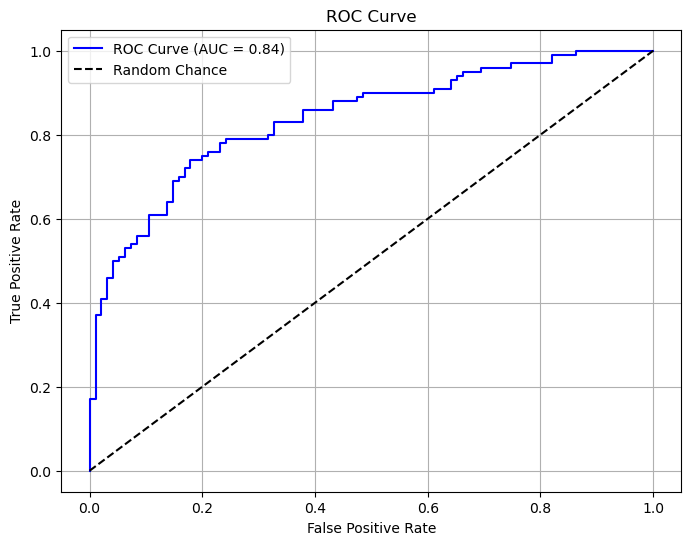

In [66]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(df_avg['target'], df_avg['avg_prob'])
auc_score = roc_auc_score(df_avg['target'], df_avg['avg_prob'])

# Plot
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.2f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')  # dashed diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()


# MLP model

Training with: hidden_layer_sizes=(32,), lr=0.0001, batch_size=16
Validation F1: 0.6834
Training with: hidden_layer_sizes=(32,), lr=0.0001, batch_size=32
Validation F1: 0.5486
Training with: hidden_layer_sizes=(32,), lr=0.0001, batch_size=64
Validation F1: 0.5428
Training with: hidden_layer_sizes=(32,), lr=0.001, batch_size=16
Validation F1: 0.7107
Training with: hidden_layer_sizes=(32,), lr=0.001, batch_size=32
Validation F1: 0.7060
Training with: hidden_layer_sizes=(32,), lr=0.001, batch_size=64
Validation F1: 0.7060
Training with: hidden_layer_sizes=(32,), lr=0.01, batch_size=16
Validation F1: 0.6841
Training with: hidden_layer_sizes=(32,), lr=0.01, batch_size=32
Validation F1: 0.6841
Training with: hidden_layer_sizes=(32,), lr=0.01, batch_size=64
Validation F1: 0.6920
Training with: hidden_layer_sizes=(64,), lr=0.0001, batch_size=16
Validation F1: 0.6345
Training with: hidden_layer_sizes=(64,), lr=0.0001, batch_size=32
Validation F1: 0.6632
Training with: hidden_layer_sizes=(64,), 

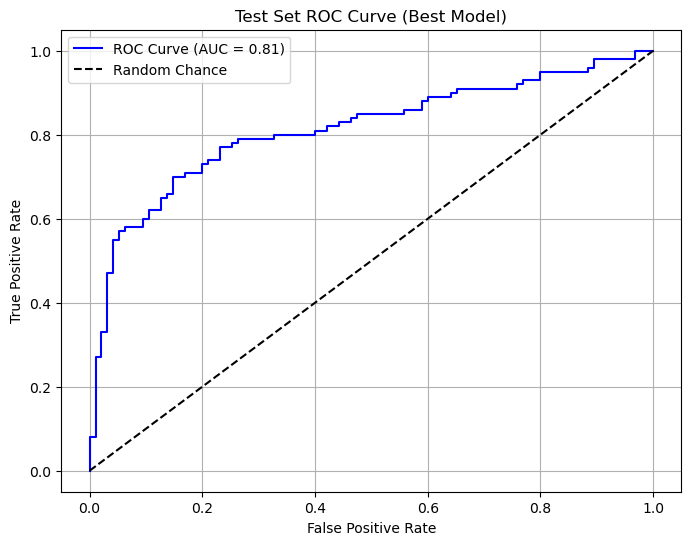

In [89]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score, accuracy_score, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Split the dataset
train_df = df[df['df_split'] == 'train']
valid_df = df[df['df_split'] == 'valid']
test_df = df[df['df_split'] == 'test']

# Features and target
features = ['text_probs', 'audio_probs', 'videomae_probs']

X_train, y_train = train_df[features], train_df['target']
X_valid, y_valid = valid_df[features], valid_df['target']
X_test, y_test = test_df[features], test_df['target']

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
X_valid_tensor = torch.tensor(X_valid, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long).to(device)
y_valid_tensor = torch.tensor(y_valid.values, dtype=torch.long).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long).to(device)

# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_layers):
        super(MLP, self).__init__()
        layers = []
        prev_dim = input_dim
        for hidden_dim in hidden_layers:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.ReLU())
            prev_dim = hidden_dim
        layers.append(nn.Linear(prev_dim, 2))  # Output layer for binary classification
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)

# Grid search parameters
param_grid = {
    'hidden_layer_sizes': [(32,), (64,), (32, 32), (20, 5), (50, 10), (52, 12), (54, 14), (56, 16), (58, 18),(60, 20), (64, 32)],
    'lr': [0.0001, 0.001, 0.01],
    'batch_size': [16, 32, 64]
}

best_valid_f1 = -1
best_model = None
best_params = {}

# Manual Grid Search
for hls in param_grid['hidden_layer_sizes']:
    for lr in param_grid['lr']:
        for batch_size in param_grid['batch_size']:
            print(f"Training with: hidden_layer_sizes={hls}, lr={lr}, batch_size={batch_size}")
            
            # Model definition
            model = MLP(input_dim=X_train.shape[1], hidden_layers=hls).to(device)
            
            # Loss and optimizer
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.Adam(model.parameters(), lr=lr)
            
            # Train the model
            model.train()
            for epoch in range(10):  # Training for 10 epochs
                for i in range(0, len(X_train), batch_size):
                    batch_X = X_train_tensor[i:i+batch_size]
                    batch_y = y_train_tensor[i:i+batch_size]
                    
                    optimizer.zero_grad()
                    outputs = model(batch_X)
                    loss = criterion(outputs, batch_y)
                    loss.backward()
                    optimizer.step()
            
            # Validate the model
            model.eval()
            with torch.no_grad():
                valid_outputs = model(X_valid_tensor)
                _, valid_preds = torch.max(valid_outputs, 1)
                valid_f1 = f1_score(y_valid, valid_preds.cpu(), average='macro')
                print(f"Validation F1: {valid_f1:.4f}")
            
            if valid_f1 > best_valid_f1:
                best_valid_f1 = valid_f1
                best_model = model
                best_params = {'hidden_layer_sizes': hls, 'lr': lr, 'batch_size': batch_size}

print("\nBest Hyperparameters:", best_params)
print(f"Best Validation F1: {best_valid_f1:.4f}")

# Final evaluation on train, valid, and test using the best_model
best_model.eval()
with torch.no_grad():
    # Train evaluation
    train_outputs = best_model(X_train_tensor)
    _, train_preds = torch.max(train_outputs, 1)
    train_f1 = f1_score(y_train, train_preds.cpu(), average='macro')
    train_acc = accuracy_score(y_train, train_preds.cpu())
    
    # Valid evaluation
    valid_outputs = best_model(X_valid_tensor)
    _, valid_preds = torch.max(valid_outputs, 1)
    valid_f1 = f1_score(y_valid, valid_preds.cpu(), average='macro')
    valid_acc = accuracy_score(y_valid, valid_preds.cpu())
    
    # Test evaluation
    test_outputs = best_model(X_test_tensor)
    _, test_preds = torch.max(test_outputs, 1)
    test_f1 = f1_score(y_test, test_preds.cpu(), average='macro')
    test_acc = accuracy_score(y_test, test_preds.cpu())

print(f"\nTrain F1: {train_f1:.4f}, Accuracy: {train_acc:.4f}")
print(f"Valid F1: {valid_f1:.4f}, Accuracy: {valid_acc:.4f}")
print(f"Test F1: {test_f1:.4f}, Accuracy: {test_acc:.4f}")

# ROC Curve for Test
test_probs = best_model(X_test_tensor).detach().cpu().numpy()[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, test_probs)
auc_score = roc_auc_score(y_test, test_probs)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.2f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Test Set ROC Curve (Best Model)')
plt.legend()
plt.grid(True)
plt.show()


Training with: hidden_layer_sizes=(3,), lr=1e-06, batch_size=32
Training with: hidden_layer_sizes=(3,), lr=1e-06, batch_size=64
Training with: hidden_layer_sizes=(3,), lr=1e-05, batch_size=32
Training with: hidden_layer_sizes=(3,), lr=1e-05, batch_size=64
Training with: hidden_layer_sizes=(3,), lr=0.0001, batch_size=32
Training with: hidden_layer_sizes=(3,), lr=0.0001, batch_size=64
Training with: hidden_layer_sizes=(3,), lr=0.001, batch_size=32
Training with: hidden_layer_sizes=(3,), lr=0.001, batch_size=64
Training with: hidden_layer_sizes=(3,), lr=0.01, batch_size=32
Training with: hidden_layer_sizes=(3,), lr=0.01, batch_size=64
Training with: hidden_layer_sizes=(4,), lr=1e-06, batch_size=32
Training with: hidden_layer_sizes=(4,), lr=1e-06, batch_size=64
Training with: hidden_layer_sizes=(4,), lr=1e-05, batch_size=32
Training with: hidden_layer_sizes=(4,), lr=1e-05, batch_size=64
Training with: hidden_layer_sizes=(4,), lr=0.0001, batch_size=32
Training with: hidden_layer_sizes=(4,),

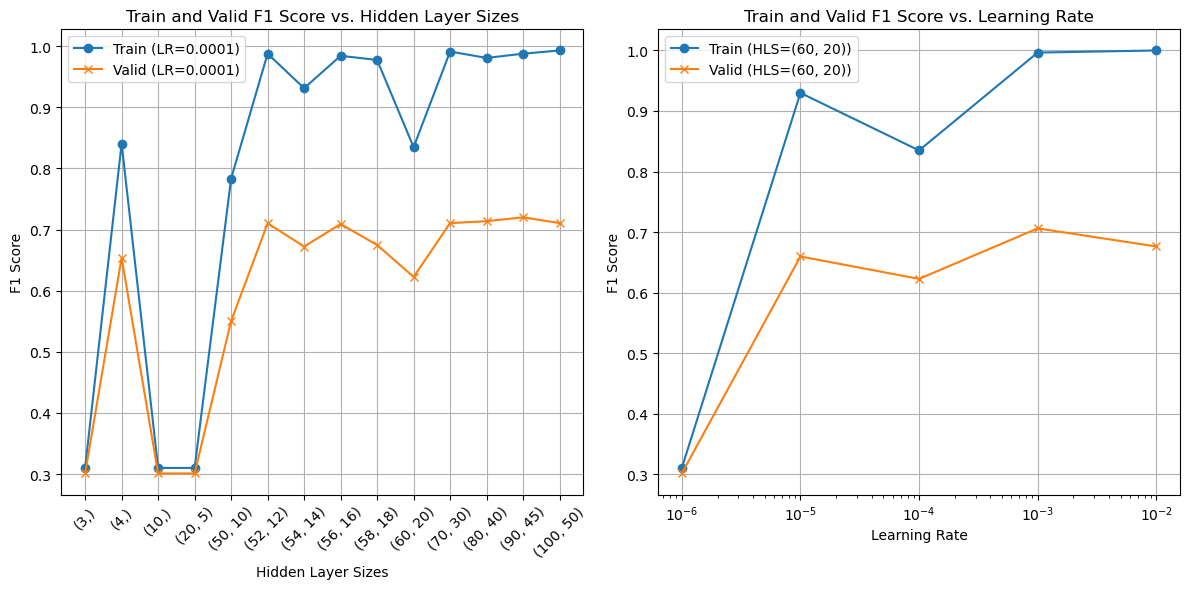

In [92]:
param_grid = {
    'hidden_layer_sizes': [(3,), (4,), (10,), (20, 5), (50, 10), (52, 12), (54, 14), (56, 16), (58, 18),(60, 20), (70, 30), (80, 40), (90, 45), (100, 50)],
    'lr': [0.000001, 0.00001, 0.0001, 0.001, 0.01],
    'batch_size': [32, 64]
}

import matplotlib.pyplot as plt
import numpy as np

# Store the results for each combination
grid_results = []

# Manual Grid Search
for hls in param_grid['hidden_layer_sizes']:
    for lr in param_grid['lr']:
        for batch_size in param_grid['batch_size']:
            print(f"Training with: hidden_layer_sizes={hls}, lr={lr}, batch_size={batch_size}")
            
            # Model definition
            model = MLP(input_dim=X_train.shape[1], hidden_layers=hls).to(device)
            
            # Loss and optimizer
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.Adam(model.parameters(), lr=lr)
            
            # Train the model
            model.train()
            for epoch in range(10):  # Training for 10 epochs
                for i in range(0, len(X_train), batch_size):
                    batch_X = X_train_tensor[i:i+batch_size]
                    batch_y = y_train_tensor[i:i+batch_size]
                    
                    optimizer.zero_grad()
                    outputs = model(batch_X)
                    loss = criterion(outputs, batch_y)
                    loss.backward()
                    optimizer.step()
            
            # Validate the model
            model.eval()
            with torch.no_grad():
                train_outputs = model(X_train_tensor)
                _, train_preds = torch.max(train_outputs, 1)
                train_f1 = f1_score(y_train, train_preds.cpu(), average='macro')
                
                valid_outputs = model(X_valid_tensor)
                _, valid_preds = torch.max(valid_outputs, 1)
                valid_f1 = f1_score(y_valid, valid_preds.cpu(), average='macro')
            
            # Store the results
            grid_results.append({
                'hidden_layer_sizes': hls,
                'lr': lr,
                'batch_size': batch_size,
                'train_f1': train_f1,
                'valid_f1': valid_f1
            })

# Convert to DataFrame for easier plotting
import pandas as pd
grid_df = pd.DataFrame(grid_results)

# ---- Plot 1: Varying hidden_layer_sizes with fixed lr and batch_size ----

plt.figure(figsize=(12, 6))

# Plot for hidden_layer_sizes
plt.subplot(1, 2, 1)
lr_value = 0.0001  # Choose a constant learning rate for this plot
batch_size_value = 32  # Choose a constant batch size for this plot

subset_hls = grid_df[(grid_df['lr'] == lr_value) & (grid_df['batch_size'] == batch_size_value)]
for lr in subset_hls['lr'].unique():
    subset = subset_hls[subset_hls['lr'] == lr]
    plt.plot([str(hls) for hls in subset['hidden_layer_sizes']], subset['train_f1'], label=f'Train (LR={lr})', marker='o')
    plt.plot([str(hls) for hls in subset['hidden_layer_sizes']], subset['valid_f1'], label=f'Valid (LR={lr})', marker='x')

plt.xlabel('Hidden Layer Sizes')
plt.ylabel('F1 Score')
plt.title('Train and Valid F1 Score vs. Hidden Layer Sizes')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

# ---- Plot 2: Varying learning rate with fixed hidden_layer_sizes and batch_size ----

plt.subplot(1, 2, 2)
hidden_layer_size_value = (60,20)  # Choose a constant hidden layer size for this plot
batch_size_value = 32  # Choose a constant batch size for this plot

subset_lr = grid_df[(grid_df['hidden_layer_sizes'] == hidden_layer_size_value) & (grid_df['batch_size'] == batch_size_value)]
for hls in subset_lr['hidden_layer_sizes'].unique():
    subset = subset_lr[subset_lr['hidden_layer_sizes'] == hls]
    plt.plot(subset['lr'], subset['train_f1'], label=f'Train (HLS={hls})', marker='o')
    plt.plot(subset['lr'], subset['valid_f1'], label=f'Valid (HLS={hls})', marker='x')

plt.xlabel('Learning Rate')
plt.ylabel('F1 Score')
plt.title('Train and Valid F1 Score vs. Learning Rate')
plt.xscale('log')  # Use log scale for better visualization
plt.legend()
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()
